## 主題：以CNN做表情辨認

### 組員：張毓倩、江育誠、黃涱煜

### 介紹：
   
    本資料來自 kaggle 網站(來源在文末連結，資料由 Mila 公司提供)，共有兩萬八千張左右48x48 pixel的圖片，每一張圖片皆有表情label，而每張圖片都只會有一種表情。總共有七種可能的表情（0：生氣, 1：厭惡, 2：恐懼, 3：高興, 4：難過, 5：驚訝, 6：中立(難以區分為前六種的表情))。此外，還有三千五百多筆 public testing data，因此我們會將兩萬八千筆 training data 以 CNN 建立出預測模型後，再利用 public testing data 評估預測準確率。
    
    (https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge)
  

### 模型建構如下：

    以兩萬八千筆有 label 的資料當作 Training data (27000 training, 1000 validation)，使用 kaggle 上 public testing data 作為測試資料(測試資料量為3589)。模型結構如下圖，由於資料量龐大因此使用 Server 跑：

 <img src="final_CNN.png" alt="drawing" style="width: 900px; height: 500px"/>

In [3]:
import csv
import numpy as np
import sys
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
      Activation, BatchNormalization, Dropout

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.optimizers import adam
import time

Using TensorFlow backend.


In [ ]:
train_num = 27000
test_num = 1000


def load_train():
   all_features = []
   all_labels = []
   count = 0
   # train_num = 5000
   with open("train.csv", 'r', encoding='big5') as file:
      file.readline()
      all_rows = csv.reader(file, delimiter=',')
      for row in all_rows:
         if count == train_num:
            break
         all_labels.append(row[0])
         all_features.append(row[1].split(' '))
         count += 1

   all_features = np.array(all_features).astype('float')
   all_features = all_features.reshape(train_num, 48, 48, 1)

   all_labels = np.array(all_labels).astype('float')
   all_labels = np_utils.to_categorical(all_labels, 7)
   print("finish at ",time.time());
   return all_features, all_labels

def load_test():
   all_features = []
   all_labels = []
   count = 0

   with open("train.csv", 'r', encoding='big5') as file:
      file.readline()
      all_rows = csv.reader(file, delimiter=',')
      for row in all_rows:
         if count > train_num:
            if count > train_num + test_num:
               break
            all_labels.append(row[0])
            all_features.append(row[1].split(' '))
         count += 1         
   
   all_features = np.array(all_features).astype('float')
   all_features = all_features.reshape(test_num, 48, 48, 1)

   all_labels = np.array(all_labels).astype('float')
   all_labels = np_utils.to_categorical(all_labels, 7)
   print("finish at ",time.time());
   return all_features, all_labels

def build_model(x_train):
   model = Sequential()
   num_classes = 7

   model.add(Conv2D(64, (3, 3), padding='same',
               input_shape=x_train.shape[1:]))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(Conv2D(64, (3, 3)))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))



   model.add(Conv2D(128, (3, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(Conv2D(256, (3, 3)))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))



   model.add(Conv2D(128, (3, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(Conv2D(128, (3, 3)))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))



   model.add(Flatten())
   model.add(Dense(512))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(Dropout(0.333))
   model.add(Dense(512))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(Dropout(0.333))

   model.add(Dense(num_classes))
   model.add(Activation('softmax'))
   print("finish at ",time.time());
   return model

X_train, Y_train = load_train()
X_test, Y_test = load_test()

## normalize ##
X_train = X_train / 255
X_test = X_test / 255



# main ##
model = build_model(X_train)
# model = load_model('model-5000.h5')
model.compile(loss='categorical_crossentropy', optimizer=adam(lr=0.005),
               metrics=['accuracy'])
model.summary()
## augmentation ##
datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=[0.8, 1.2],
            shear_range=0.2,
            horizontal_flip=True)
      
#model.fit(X_train, Y_train, batch_size=256, epochs=50, shuffle=True)
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=128), 
            steps_per_epoch=5*len(X_train)//128,
            validation_data=(X_test, Y_test),
            epochs=50, workers = 10, shuffle=True)

model.save('model-augmentation.h5')

### Training result：

    由於過程顯示的資訊量太多，只顯示最後一個 epoch 的資訊：
     

 <img src="final.png" alt="drawing" style="width: 900px; height: 500px"/>

    Training set (27000) accuracy : 0.9756
    Validation set (1000) accuracy : 0.6830

### Training accuracy 的趨勢圖：
    
    也是使用 Server 來跑，如下圖：

In [ ]:
plt.plot(model.history["acc"])
plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.savefig('books_read.png')

 <img src="62218080_2267043480201250_1916741671098253312_n.png" alt="drawing" style="width: 900px; height: 500px"/>

    可從圖中觀察出前 10 個 epoch 時 accuracy 很快，大約在 40 之後開始收斂。

### 測試評估 (Testing data)：

In [16]:
import csv
import numpy as np
import sys
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
      Activation, BatchNormalization, Dropout

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.optimizers import adam
def load_test():
   all_features = []
   all_labels = []
   count = 0

   with open("fer2013.csv", 'r', encoding='big5') as file:
      file.readline()
      all_rows = csv.reader(file, delimiter=',')
      for row in all_rows:
         if row[2] == 'Training':
            continue
         all_labels.append(row[0])
         all_features.append(row[1].split(' '))
         count += 1

   all_features = np.array(all_features).astype('float')
   all_features = all_features.reshape(count, 48, 48, 1)

   all_labels = np.array(all_labels).astype('float')
   all_labels = np_utils.to_categorical(all_labels, 7)

   return all_features, all_labels

def build_model(x_train):
   model = Sequential()
   num_classes = 7

   model.add(Conv2D(64, (3, 3), padding='same',
               input_shape=x_train.shape[1:]))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(Conv2D(64, (3, 3)))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))



   model.add(Conv2D(128, (3, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(Conv2D(256, (3, 3)))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))



   model.add(Conv2D(128, (3, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(Conv2D(128, (3, 3)))
   model.add(BatchNormalization())
   model.add(Activation('relu'))

   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))



   model.add(Flatten())
   model.add(Dense(512))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(Dropout(0.333))
   model.add(Dense(512))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(Dropout(0.333))

   model.add(Dense(num_classes))
   model.add(Activation('softmax'))
   print("finish at ",time.time());

   return model



X_test, Y_test = load_test()


X_test = X_test / 255

## augmentation ##
datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=[0.8, 1.2],
            shear_range=0.2,
            horizontal_flip=True)


# main ##
#model = build_model(X_train)
model = load_model("model-augmentation.h5")
model.compile(loss='categorical_crossentropy', optimizer=adam(lr=0.001),
               metrics=['accuracy'])
model.summary()


test_acc =  model.evaluate(X_test, Y_test)
print('test accuracy is: ', test_acc[1])

model.save_weights('model-3000-0.68.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
__________

### Testing data accuracy：67.05%

### Model comparison：
    
    該比賽在2013年的冠軍Accuracy僅為34%，我們使用一個藉由相同資料發表的model作為比較(來源如網址)，該model的Accuracy為57%，而我們則為67.05%，以下就來透過比較來突顯出我們model的特點。
    
    
    (https://l.facebook.com/l.php?u=https%3A%2F%2Fsefiks.com%2F2018%2F01%2F01%2Ffacial-expression-recognition-with-keras%2F%3Ffbclid%3DIwAR0IFtLwvk4NBSx8AuIXEWmkoa66HIpr3scn6bfNep3Ota-7_qqegFvWTAU&h=AT2xOVuWldll6qJDRdGSwNDHtIHmoh2OsrusEt0NBYxXNqEvEVMNyEPsn0qKMH9aWFwc5fImxdEsUpIo2ZcU1cyybP219AfblGhKvxnfcGNNCB4Fp8aLjXK01OfkgUxVoNczvA)

### 比較模型的程式碼：

In [6]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [12]:
import csv
from keras.utils import np_utils

In [13]:
#------------------------------
#cpu - gpu configuration
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
#------------------------------

In [14]:
#variables
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 5
#------------------------------

In [15]:
#read kaggle facial expression recognition challenge dataset (fer2013.csv)
#https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

with open("fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))


number of instances:  35888
instance length:  2304


In [16]:
#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("",end="")

#------------------------------

In [17]:
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#------------------------------

28709 train samples
3589 test samples


In [9]:
#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
#------------------------------

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         147584    
__________

In [11]:
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)


#------------------------------

model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

#------------------------------


#### 直接使用原作者Train好的 weight：

In [12]:
fit = False

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs) #train for randomly selected one
else:
	model.load_weights('facial_expression_model_weights.h5') #load weights
	
#------------------------------

In [13]:
#overall evaluation
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])

3589/3589 [==============================] - 6s 2ms/step
Test loss: 2.279457059036759
Test accuracy: 57.42546670713874


#### 該作者的 Testing accuracy 為 57.42%，比我們少了將近 10 %。

### 模型比較結論：

    我們的 model 與該作者的最大差異在於 model.fit_generator() 中的參數："shuffle"。Shuffle 參數是布林值，代表是否在每輪迭代之前打亂數據，就是每次取出 bactch size 資料時是隨機的，意即並非按照資料序列取出資料。
    未加入 shuffle 前，我們的 testing accuracy 大約只有 57~58%，加入後立即提升為 63%，之後再加入 data augmentation 之後則為 68%。至於data augmentation 的參數我們也是 try and error，提升的原因可能在於經過 augmentation 後，模型能捕捉到更多資訊。
    使用 Shuffle 有很大的差異的可能原因在於，若按照資料順序去訓練的話，也許無法較全面地捕捉到資料的變化，因此將 Training set 做隨機的抽取是有其必要性的。

### 實際測試我們自己的照片：

In [1]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [4]:
model = load_model("model-augmentation.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### 原圖1：悲傷

 <img src="sad.jpg" alt="drawing" style="width: 300px; height: 300px"/>

C:\Users\Rynk\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


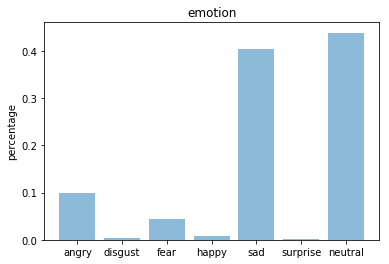

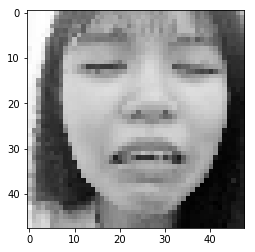

In [7]:
#make prediction for custom image out of test set

img = image.load_img("sad.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

雖然 Neutral 的比例較高，但與 Sad 的比例幾乎等同，因此悲傷的估計尚且還算準確。

### 原圖2：驚訝

 <img src="surprise.jpg" alt="drawing" style="width: 300px; height: 300px"/>

C:\Users\Rynk\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


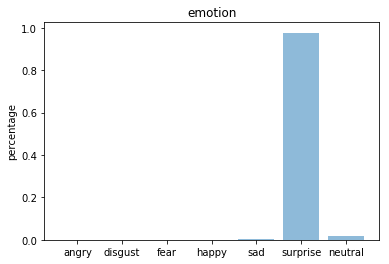

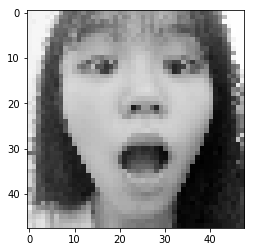

In [21]:
img = image.load_img("surprise.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

只估計出驚訝的成分！驚訝的表情估計非常精確！！

### 原圖3：恐懼

 <img src="fear.jpg" alt="drawing" style="width: 300px; height: 300px"/>

C:\Users\Rynk\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


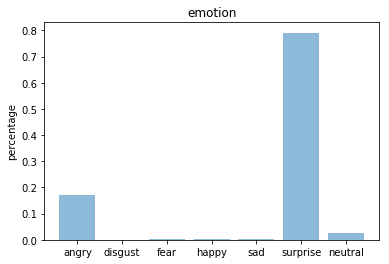

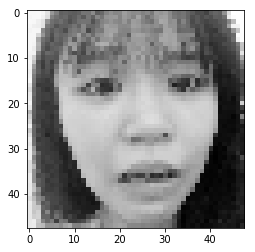

In [22]:
img = image.load_img("fear.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

恐懼的表情判斷為驚訝，看來對於恐懼的預測不太準確。

### 討論：

    FER2013 為非常知名的比賽，很多表情辨識的愛好者都利用此資料才研發自己的CNN model，但是預測率卻始終無法達到80~90%以上，於是我們對此做出了探討：如上面三圖為例，model不一定能預測出我們對於自己的表情label，根本原因可能在於"表情判定"本來就是有主觀意識的，若這兩萬八千多筆資料在 label 時沒有一定的標準，那麼神經網路自然沒辦法有跡可循。因此做深度學習的同時，必須先確定 label 的一致性與正確性。